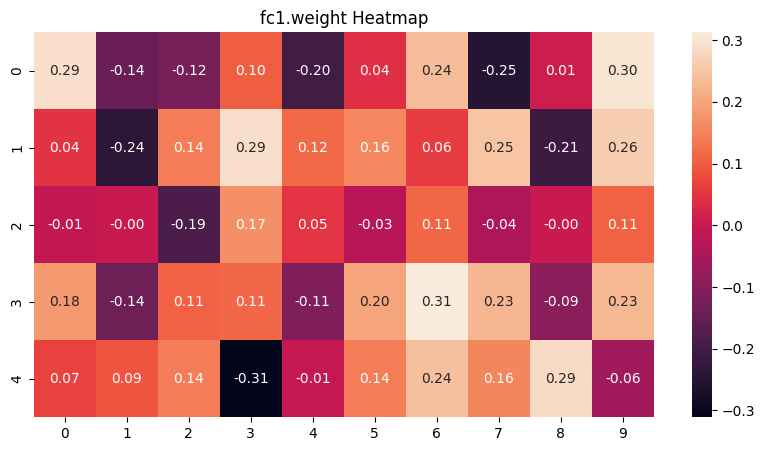

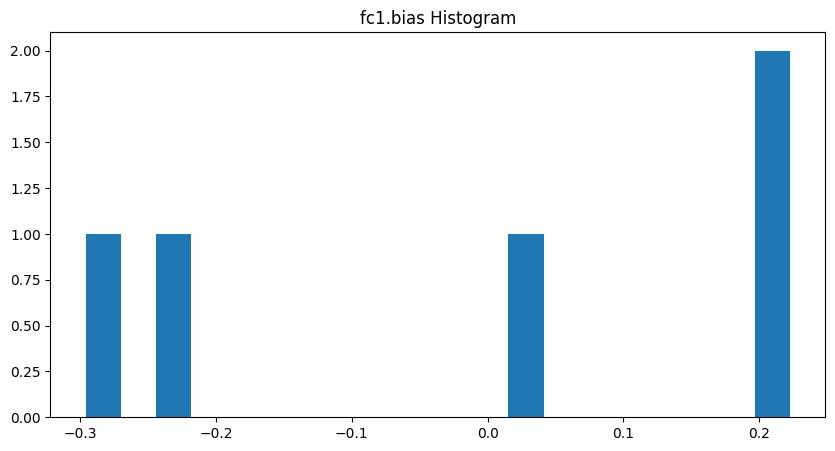

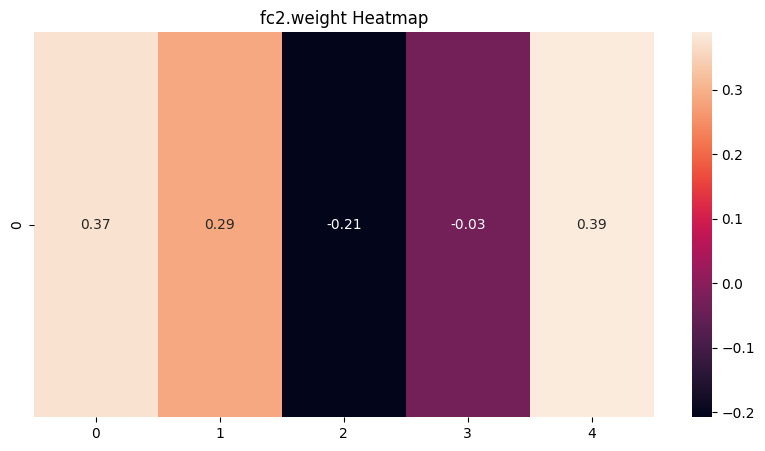

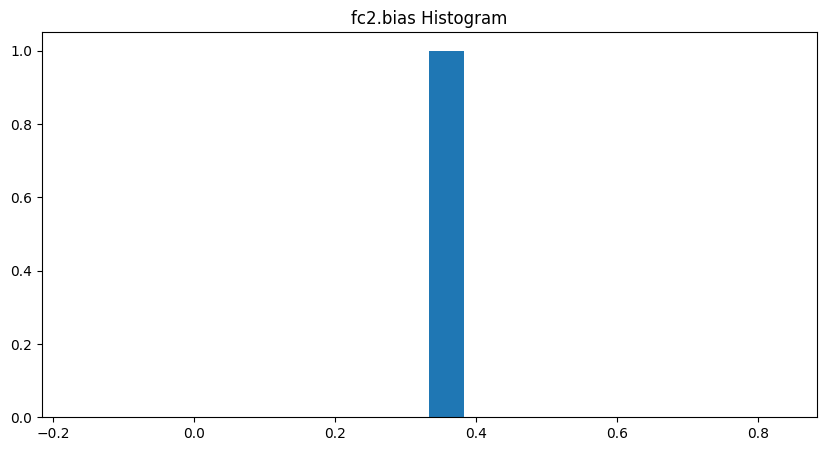

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Create a simple linear model
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Function to extract model parameters
def extract_params(model):
    params_dict = {}
    for name, param in model.named_parameters():
        params_dict[name] = param.data.cpu().numpy()
    return params_dict

def extract_model_params(model):
    layers = []
    for name, param in model.named_parameters():
        if "weight" in name:
            layers.append(param.data)
    return layers

# Function to visualize model parameters
def visualize_params(params_dict):
    for name, param in params_dict.items():
        plt.figure(figsize=(10, 5))
        if 'weight' in name:
            sns.heatmap(param, annot=True, fmt=".2f")
            plt.title(f"{name} Heatmap")
        elif 'bias' in name:
            plt.hist(param, bins=20)
            plt.title(f"{name} Histogram")
        plt.show()

# Function to visualize the whole model
def visualize_model(model):
    params_dict = extract_params(model)
    visualize_params(params_dict)

# Generate some random data
x = torch.randn(50, 10)

# Initialize and run the model
model = SimpleLinearModel()
y_pred = model(x)

# Visualize the model
visualize_model(model)


In [1]:
from OpenGL.GL import *
from OpenGL.GLUT import *
import glfw
import numpy as np
from threading import Thread
import random
from OpenGL import GLUT

In [9]:
def draw_text(x, y, text, font=GLUT.GLUT_BITMAP_8_BY_13):
    glRasterPos2f(x, y)
    for ch in text:
        glutBitmapCharacter(font, ord(ch))

class Neuron:

    def interpolate_color(self, color1, color2, t):
        """ Interpolate between two colors """
        return tuple(a + (b - a) * t for a, b in zip(color1, color2))

    def random_color(self):
        if self.value < 0.5:
            # Choose a shade of red
            r,g,b = self.interpolate_color((1, 0, 0), (1, 1, 1), self.value / 0.5)
        else:
            # Choose a shade of blue
            r,g,b = self.interpolate_color((1, 1, 1), (0, 0, 1), (self.value - 0.5) / 0.5)
        a = abs(2*(self.value - 0.5))
        return r,g,b,a

    def __init__(self, x, y, radius=0.05):
        self.x = x
        self.y = y
        self.radius = radius
        self.value = random.random()
        self.color = self.random_color()  # Random red component

    def draw(self):
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        glColor4f(*self.color)  # White color
        glBegin(GL_TRIANGLE_FAN)
        glVertex2f(self.x, self.y)
        for angle in np.linspace(0, 2 * np.pi, 15):
            glVertex2f(self.x + self.radius * np.cos(angle), self.y + self.radius * np.sin(angle))
        glEnd()
        
        #draw_text(self.x, self.y, str((self.value-0.5)*2))

In [23]:
class Layer:
    def __init__(self, neuron_count, layer_index, total_layers, radius=0.05):
        self.neurons = []
        self.layer_index = layer_index
        self.total_layers = total_layers

        # Calculate center and vertical gap between neurons
        vertical_center = 0  # This is the vertical center, adjust if your center is different
        vertical_gap = max(0.8/(neuron_count)**2, radius*2 + 0.02)  # Adjust the gap as needed
        half_height = (neuron_count - 1) * vertical_gap / 2

        for i in range(neuron_count):
            # Vertical position centered around the vertical_center
            y = vertical_center + (vertical_gap * i) - half_height
            self.neurons.append(Neuron(self.get_layer_x_position(), y, radius))


    def get_layer_x_position(self):
        # Horizontal position based on layer index
        layer_gap = 2.0 / (self.total_layers + 1)
        return -1 + layer_gap + (self.layer_index * layer_gap)

    def draw(self):
        for neuron in self.neurons:
            neuron.draw()


In [4]:
import random

class Connection:

    
    def interpolate_color(self, color1, color2, t):
        """ Interpolate between two colors """
        return tuple(a + (b - a) * t for a, b in zip(color1, color2))

    def random_color(self):
        t = random.random()
        if t < 0.5:
            # Choose a shade of red
            r,g,b = self.interpolate_color((1, 0, 0), (1, 1, 1), t / 0.5)
        else:
            # Choose a shade of blue
            r,g,b = self.interpolate_color((1, 1, 1), (0, 0, 1), (t - 0.5) / 0.5)
        a = abs(2*(t - 0.5))
        return r,g,b,a

    def __init__(self, start_neuron, end_neuron, width=0.5):
        self.start_neuron = start_neuron
        self.end_neuron = end_neuron
        self.width = 0.1

        self.color = self.random_color()  # Random red component

    def draw(self):
        # Set line width
        glLineWidth(self.width)

        # Optionally enable line smoothing
        glEnable(GL_LINE_SMOOTH)
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        glHint(GL_LINE_SMOOTH_HINT, GL_NICEST)
        glColor4f(*self.color)  # Set the random color

        glBegin(GL_LINES)
        glVertex2f(self.start_neuron.x, self.start_neuron.y)
        glVertex2f(self.end_neuron.x, self.end_neuron.y)
        glEnd()

In [49]:
class Network:
    def __init__(self, layer_structure):
        self.layers = []
        self.connections = []  # List to store connections

        # Create layers
        total_layers = len(layer_structure)
        limiting_factor = max(total_layers, max(layer_structure))

        for i, neuron_count in enumerate(layer_structure):
            self.layers.append(Layer(neuron_count, i, total_layers, 0.8/limiting_factor))

        # Create connections between layers
        for i in range(len(self.layers) - 1):
            for neuron in self.layers[i].neurons:
                for next_neuron in self.layers[i + 1].neurons:
                    self.connections.append(Connection(neuron, next_neuron))

    def draw(self):
        # Draw connections first
        for connection in self.connections:
            connection.draw()

        # Then draw layers
        for layer in self.layers:
            layer.draw()


In [53]:


def draw_symmetry_line():
    glColor3f(0, 1, 0)  # Set color to green (or any color you prefer)
    glBegin(GL_LINES)
    glVertex2f(-1, 0)  # Start point at left side of the window
    glVertex2f(1, 0)   # End point at right side of the window
    glEnd()


network = Network([15, 5,20,15,15,5,10])  # Example: 3 layers with 3, 4, and 2 neurons respectively

def draw_shapes():

    """
    # Draw white circle
    glColor3f(1, 1, 1)
    glBegin(GL_TRIANGLE_FAN)
    glVertex2f(0, 0)
    for angle in np.linspace(0, 2 * np.pi, 100):
        x = 0.5 * np.cos(angle)
        y = 0.5 * np.sin(angle)
        glVertex2f(x, y)
    glEnd()

    # Draw red line
    glColor3f(1, 0, 0)
    glBegin(GL_LINES)
    glVertex2f(-1, -1)
    glVertex2f(1, 1)
    glEnd()
    """

    draw_symmetry_line()
    network.draw()

    
def run_glfw_window():
    if not glfw.init():
        return

    window = glfw.create_window(640, 480, "GLFW Window", None, None)
    if not window:
        glfw.terminate()
        return

    glfw.make_context_current(window)

    while not glfw.window_should_close(window):
        glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
        draw_shapes()
        glfw.swap_buffers(window)
        glfw.poll_events()

    glfw.terminate()

# Run in a separate thread
thread = Thread(target=run_glfw_window)
thread.start()


In [11]:
import glfw
from OpenGL.GL import *
from OpenGL.GL.shaders import compileProgram, compileShader
import numpy as np

window_width = 800
window_height = 600

# Initialize a scaling factor
scale = 1.0

panning = False  # Initialize panning flag
down_x, down_y = 0.0, 0.0
global delta_x
global delta_y

delta_x, delta_y = 0.0, 0.0

def mouse_button_callback(window, button, action, mods):
    global panning, down_x, down_y
    if button == glfw.MOUSE_BUTTON_LEFT:
        if action == glfw.PRESS:
            panning = True
            down_x, down_y = glfw.get_cursor_pos(window)
            
            print(down_x, down_y)
            #prev_x = prev_x/2
            #prev_y = 1 - 2*prev_y
            
        elif action == glfw.RELEASE:
            panning = False
            
# The scroll callback function
def scroll_callback(window, x_offset, y_offset):
    global scale
    scale += y_offset * 0.1  # Adjust this factor as needed
    if scale < 0.1:  # Prevent it from getting too small
        scale = 0.1
        
    transformMatrix[0, 0] = scale  # Scaling in the x-direction
    transformMatrix[1, 1] = scale  # Scaling in the y-direction

# Transformation matrix
transformMatrix = np.eye(4, dtype=np.float32)

def cursor_position_callback(window, xpos, ypos):
    global transformMatrix  # Make sure this variable is accessible
    # Convert cursor position to OpenGL coordinates if needed
    
    delta_x = xpos - down_x
    delta_y = ypos - down_y
    
    normalized_x = xpos / window_width
    normalized_y = ypos / window_height
    
    opengl_x = 2 * normalized_x - 1
    opengl_y = 1 - 2 * normalized_y
    
    print(normalized_x,normalized_y )

    transformMatrix[0, 3] = opengl_x
    transformMatrix[1, 3] = opengl_y


# Initialize GLFW
if not glfw.init():
    raise Exception("GLFW could not be initialized")

# Create GLFW window
window = glfw.create_window(window_width, window_height, "My OpenGL Window", None, None)

# Make the window's OpenGL context current
glfw.make_context_current(window)

# Create shader program
vertex_shader = open("vertex_shader.glsl", "r").read()
fragment_shader = open("fragment_shader.glsl", "r").read()

shader = compileProgram(
    compileShader(vertex_shader, GL_VERTEX_SHADER),
    compileShader(fragment_shader, GL_FRAGMENT_SHADER)
)

# Quad vertices
quad = np.array([
    -0.5, -0.5, 0.0, 0.0, 0.0,
     0.5, -0.5, 0.0, 1.0, 0.0,
     0.5,  0.5, 0.0, 1.0, 1.0,
    -0.5,  0.5, 0.0, 0.0, 1.0
], dtype=np.float32)

# Create VBO and VAO
VBO = glGenBuffers(1)
VAO = glGenVertexArrays(1)

# Bind and upload data
glBindVertexArray(VAO)
glBindBuffer(GL_ARRAY_BUFFER, VBO)
glBufferData(GL_ARRAY_BUFFER, quad, GL_STATIC_DRAW)

# Position attribute
glVertexAttribPointer(0, 3, GL_FLOAT, GL_FALSE, 5 * 4, ctypes.c_void_p(0))
glEnableVertexAttribArray(0)

# Texture coordinates attribute
glVertexAttribPointer(1, 2, GL_FLOAT, GL_FALSE, 5 * 4, ctypes.c_void_p(12))
glEnableVertexAttribArray(1)

# Generate texture ID
texture = glGenTextures(1)

# Bind it as a 2D texture
glBindTexture(GL_TEXTURE_2D, texture)

# Set texture parameters
glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_WRAP_S, GL_CLAMP_TO_EDGE)
glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_WRAP_T, GL_CLAMP_TO_EDGE)
glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)

# Create an empty 64x64 texture
width, height = 64, 64
texture_data = np.zeros((width, height, 4), dtype=np.uint8)

# Fill in the pixels
center_x, center_y = width // 2, height // 2
radius = min(center_x, center_y)

for y in range(height):
    for x in range(width):
        dx = x - center_x
        dy = y - center_y
        distance = np.sqrt(dx * dx + dy * dy)
        
        if distance < radius:
        #if distance:
            texture_data[y, x] = [255, 255, 255, 255]  # RGBA: White
        else:
            texture_data[y, x] = [0, 0, 0, 0]  # RGBA: Transparent

# Upload it to GPU
glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, width, height, 0, GL_RGBA, GL_UNSIGNED_BYTE, texture_data)

# Unbind the texture
glBindTexture(GL_TEXTURE_2D, 0)

glfw.set_cursor_pos_callback(window, cursor_position_callback)

# Set the scroll callback
glfw.set_scroll_callback(window, scroll_callback)

glfw.set_mouse_button_callback(window, mouse_button_callback)

# Use program
glUseProgram(shader)

# Initialize last time checked
last_time = glfw.get_time()
frame_count = 0

transform_loc = glGetUniformLocation(shader, "transformMatrix")
glUniformMatrix4fv(transform_loc, 1, GL_FALSE, transformMatrix.T)

# Loop
while not glfw.window_should_close(window):
    # Clear screen
    glClear(GL_COLOR_BUFFER_BIT)
        
    if panning:
        # Set the transformation uniform
        transform_loc = glGetUniformLocation(shader, "transformMatrix")
        glUniformMatrix4fv(transform_loc, 1, GL_FALSE, transformMatrix.T)
    
    # In your main loop, before drawing
    glActiveTexture(GL_TEXTURE0)
    glBindTexture(GL_TEXTURE_2D, texture)

    texture_loc = glGetUniformLocation(shader, "circleTexture")
    glUniform1i(texture_loc, 0)

    # Draw
    glBindVertexArray(VAO)
    glDrawArrays(GL_QUADS, 0, 4)
    
    glfw.swap_buffers(window)
    glfw.poll_events()
    
    # Calculate FPS
    current_time = glfw.get_time()
    frame_count += 1
    if current_time - last_time >= 1.0:  # If one second has passed
        print(f"FPS: {frame_count}")
        frame_count = 0
        last_time = current_time
    
glfw.terminate()


0.35375 0.12666666666666668
0.35375 0.12833333333333333
0.35375 0.13333333333333333
0.35625 0.14
0.35625 0.14166666666666666
0.3575 0.14833333333333334
0.35875 0.14833333333333334
0.3625 0.15666666666666668
0.37 0.16833333333333333
0.3825 0.18166666666666667
0.3825 0.18333333333333332
0.4 0.20166666666666666
0.42 0.22166666666666668
0.42125 0.22333333333333333
0.4225 0.22333333333333333
0.44625 0.24833333333333332
0.4475 0.25
0.475 0.2783333333333333
0.50375 0.305
0.505 0.305
0.50625 0.30666666666666664
0.52875 0.325
0.52875 0.32666666666666666
0.545 0.3383333333333333
0.555 0.345
0.55625 0.3466666666666667
0.56125 0.35
0.565 0.3516666666666667
0.56625 0.3516666666666667
0.5675 0.35333333333333333
0.57125 0.3516666666666667
0.57375 0.345
0.5775 0.3383333333333333
0.58375 0.32666666666666666
0.58375 0.325
0.59125 0.31
0.6025 0.28833333333333333
0.60375 0.2866666666666667
0.605 0.285
0.61625 0.25833333333333336
0.62625 0.22333333333333333
0.6275 0.22
0.6325 0.19
0.63375 0.19
0.63375 0.18